# Support Vector Machines para detección de caras

Es posible utilizarlo porque en este caso todas las imagenes son iguales, hay coincidencia de las posiciones aproximadas que tienen los pixeles que se consideran características relevantes, los rasgos que buscamos son comparables, etc. 
De no ser así, sería mejor utilizar otras opciones distintas a SVM, como OpenCV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploración del Dataset

In [2]:
# usamos un dataset de prueba que contiene caras de gente famosa
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=50)

In [3]:
print("Número de imagenes: ", str(faces.images.shape[0]))
print("Tamaño de las imágenes: ", str(faces.images.shape[1]), "x", str(faces.images.shape[2]))
print("Nombres de famosos incluidos: " + str(faces.target_names))

Número de imagenes:  1560
Tamaño de las imágenes:  62 x 47
Nombres de famosos incluidos: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']


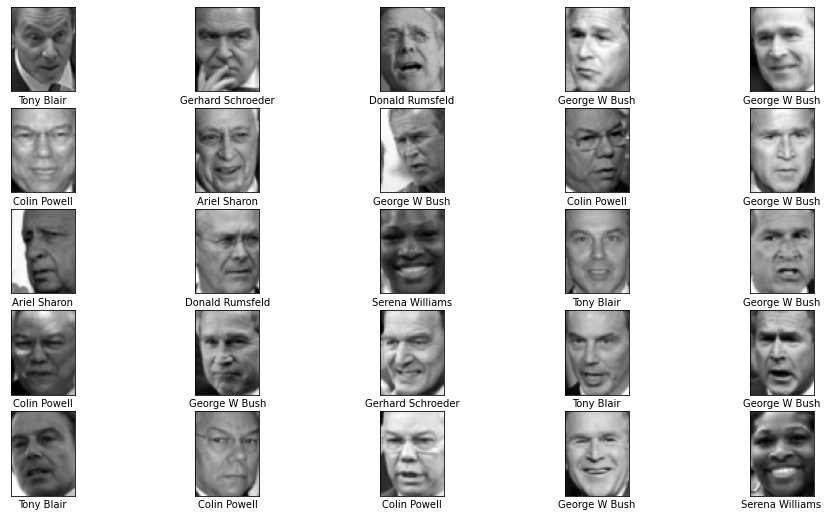

In [4]:
# representamos las imagenes

fig, ax = plt.subplots(5,5, figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(faces.images[i], cmap="gray")
    ax_i.set(xticks=[], yticks=[],xlabel=faces.target_names[faces.target[i]])

## Conjuntos de entrenamiento y prueba

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(faces.data, faces.target, test_size = 0.2, random_state = 50)

print("Entrenamiento: " + str(len(X_train)))
print("Test: " + str(len(X_test)))

Entrenamiento: 1248
Test: 312


## Modelo SVM

In [6]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [7]:
# Cada Imagen tiene Ancho x Alto componentes (aprox 3000 en nuestro caso), nos quedamos con un subconjunto de ellos, p.ej. 500

pca = RandomizedPCA(n_components=500, whiten=True, random_state=50)

# uso un kernel radial ya que para las imagenes sera mas interesante obtener rasgos cirulares que los clasifiquen
# balanced para que el clasificador pondere cuales son los rasgos mas relevantes por si mismo
svc = SVC(kernel="rbf", class_weight="balanced")

model= make_pipeline(pca, svc)

In [8]:
# vamos a combinar la posibilidad de elegir la C, que controla lo permisivo que es el margen del clasificador
# y el parametro gamma, que permite controlar el tamaño de la función radial, forma parte del caulculo del radio
params_grid = {
    "svc__C": [0.1, 1, 5, 10, 50],
    "svc__gamma": [0.0001, 0.0005, 0.001, 0.005, 0.1]
}

# va a ejecutar todo el pipeline anterior y 
# luego hara la validación cruzada con la lista de parametros que he creado en la parrilla param_grid
grid = GridSearchCV(model, params_grid) 

%time grid.fit(X_train, Y_train)

Wall time: 4min 19s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=500, random_state=50,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.1, 1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.1]})

In [9]:
print("Valores óptimos para nuestro caso: ", str(grid.best_params_))

# si se encontrasen cerca de los bordes, deberiamos repetir el experimento dandole más valores para asegurarnos
# de que es el optimo y que tiene margen para poder probar con valores mayores o menores

Valores óptimos para nuestro caso:  {'svc__C': 10, 'svc__gamma': 0.0001}


## Predicciones con el conjunto de test

In [10]:
classifier = grid.best_estimator_
yfit = classifier.predict(X_test)

Text(0.5, 0.98, 'Predicciones para nuevas imágenes (marcamos las incorrectas en rojo)')

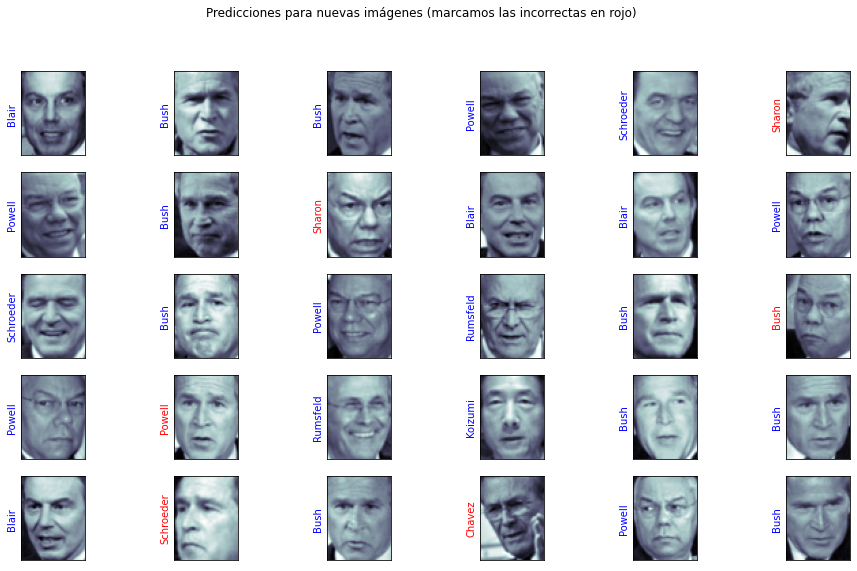

In [11]:
## Representamos el resultado

fig, ax = plt.subplots(5,6, figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(X_test[i].reshape(62,47), cmap="bone")
    ax_i.set(xticks=[], yticks=[])
    ax_i.set_ylabel(faces.target_names[yfit[i]].split()[-1], color = "blue" if yfit[i]==Y_test[i] else "red")

fig.suptitle("Predicciones para nuevas imágenes (marcamos las incorrectas en rojo)")

## Evaluación del modelo

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

In [13]:
print(classification_report(Y_test, yfit, target_names = faces.target_names))

# Recordatorio:
## precision = especifidad (verdaderos aciertos)
## recall = sensibilidad (falsos negativos)

                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.67      0.63        18
     Colin Powell       0.60      0.74      0.66        50
  Donald Rumsfeld       0.55      0.70      0.62        23
    George W Bush       0.91      0.82      0.86        96
Gerhard Schroeder       0.75      0.75      0.75        24
      Hugo Chavez       0.64      0.64      0.64        11
   Jacques Chirac       0.54      0.64      0.58        11
    Jean Chretien       0.67      0.36      0.47        11
    John Ashcroft       1.00      0.71      0.83        14
Junichiro Koizumi       1.00      0.78      0.88         9
  Serena Williams       0.89      0.57      0.70        14
       Tony Blair       0.74      0.81      0.77        31

         accuracy                           0.74       312
        macro avg       0.74      0.68      0.70       312
     weighted avg       0.76      0.74      0.74       312



### Matriz de confusión

<AxesSubplot:>

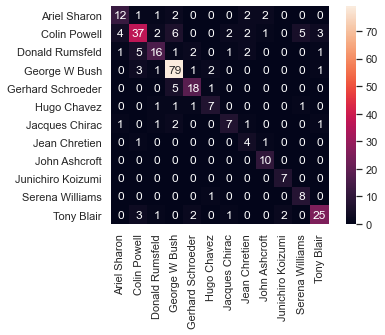

In [14]:
## Quien ha sido confundido con quien cuantas veces?

mat = confusion_matrix(Y_test, yfit)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=faces.target_names, yticklabels=faces.target_names)